# Phase Retrieval

Following Hanser et. al.,

## Notes

Noise will quickly corrupt the phase retrieval. The background has to be suppressed well.

In [1]:
%load_ext autoreload
%autoreload 2
import os
import tqdm
from skimage.external import tifffile as tif
%pylab inline
from pyOTF import *

from dphutils import scale, fft_pad
from skimage.restoration import unwrap_phase
from dphplotting import mip, slice_plot, display_grid

Populating the interactive namespace from numpy and matplotlib


In [2]:
test_data = tif.imread("../fixtures/psf_wl520nm_z300nm_x130nm_na0.85_n1.0.tif")
params = dict(
    size = test_data.shape[-1],
    zsize = test_data.shape[0],
    na = 0.85,
    res = 130,
    zres = 300,
    wl = 520,
    ni = 1.0,
    vec_corr="none",
    condition="none"
)

C:\Anaconda3\lib\site-packages\skimage\external\tifffile\tifffile.py:1398: UserWarning: tags are not ordered by code
  warnings.warn("tags are not ordered by code")


test_data = tif.imread("../fixtures/BIL113_zstack_z300nm_current.tif")
params = dict(
    size = test_data.shape[-1],
    zsize = test_data.shape[0],
    na = 1.1,
    res = 90.5,
    zres = 300,
    wl = 605,
    ni = 1.33,
    vec_corr="none",
    condition="none"
)

(<matplotlib.figure.Figure at 0x1aa5c48e208>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001AA5C75E320>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001AA5D4B3B38>], dtype=object))

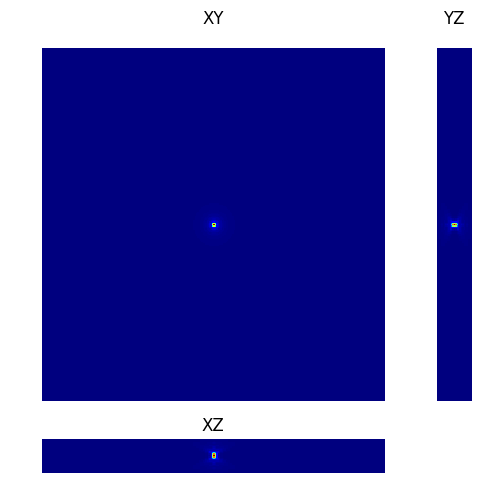

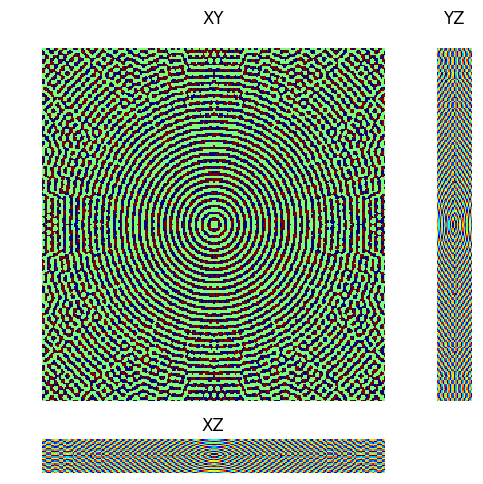

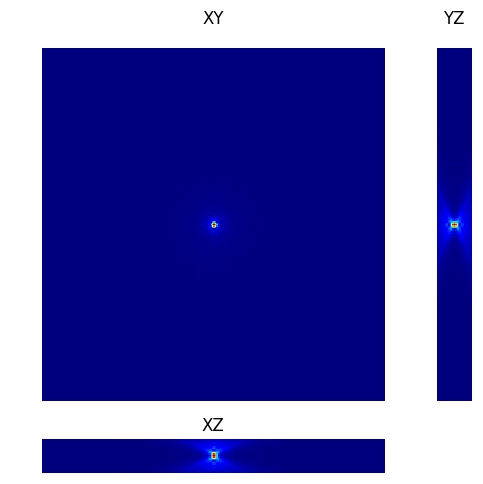

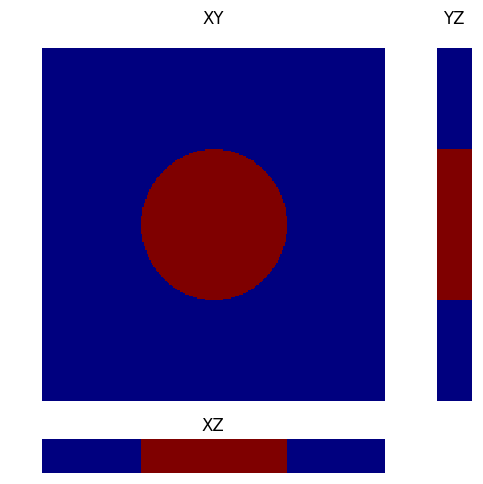

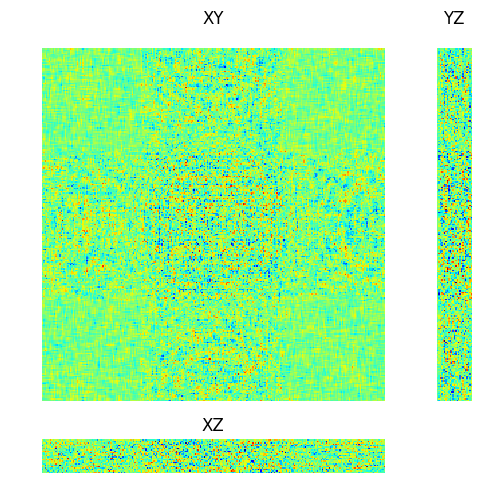

In [3]:
# some diagnostics to check the behaviour is correct
psf = HanserPSF(**params)
mip(psf.PSFi)
slice_plot(angle(psf.PSFa[0]))
slice_plot(abs(psf.PSFa[0]))
new_pupils = fftn(ifftshift(psf.PSFa[0], axes=(1,2)), axes=(1,2)) / psf._calc_defocus()
slice_plot(fftshift(new_pupils).real)
slice_plot(fftshift(new_pupils).imag)

In [4]:
def center_data(data):
    """Utility to center the data
    
    Parameters
    ----------
    data : ndarray
        Array of data points
        
    Returns
    -------
    centered_data : ndarray same shape as data
        data with max value at the central location of the array
    """
    # copy data
    centered_data = data.copy()
    # extract shape and max location
    data_shape = data.shape
    max_loc = unravel_index(data.argmax(), data_shape)
    # iterate through dimensions and roll data to the right place
    for i, (x0, nx) in enumerate(zip(max_loc, data_shape)):
#         print("x0 = {}, nx = {}".format(x0, nx))
        centered_data = roll(centered_data, (nx + 1)//2 - x0, i)
    return centered_data

In [5]:
def remove_bg(data, multiplier=1.5):
    """Utility that measures mode of data and subtracts it"""
    mode = np.bincount(data.astype(int).ravel()).argmax()
    return data - multiplier * mode

In [6]:
def psqrt(data):
    """Take the positive square root of data, any negative values will be set to zero."""
    sdata = zeros_like(data)
    sdata[data > 0] =sqrt(data[data > 0])
    return sdata

In [7]:
def retrieve_phase_iter(mag, psf, pupil=None):
    """The phase retrieval step"""
    # generate pupil if first iter
    if pupil is None:
        pupil = psf._gen_pupil()
    # generate the psf
    psf._gen_psf(pupil)
    # keep phase
    phase = angle(psf.PSFa.squeeze())
    # replace magnitude with experimentally measured mag
    new_psf = mag * exp(1j * phase)
    # generate the new pupils
    new_pupils = fftn(ifftshift(new_psf, axes=(1,2)), axes=(1,2))
    # undo defocus and take the mean and mask off values outside passband
    # might want to unwrap phase before taking mean
    new_pupil = psf._gen_pupil() * (new_pupils / psf._calc_defocus()).mean(0)
    # if phase only discard magnitude info, the following avoids divide by zero
    return new_pupil, new_pupils

In [8]:
from collections import namedtuple

In [9]:
PhaseRetrievalResult = namedtuple("PhaseRetrievalResult", ["mag", "phase", "mse", "pupil_diff", "mse_diff"])

In [10]:
def retrieve_phase(data, params, max_iters=200, pupil_tol=1e-10, mse_tol=np.nan, phase_only=False):
    """Code that actually runs the phase retrieval
    
    Parameters
    ----------
    data : ndarray (3 dim)
        The experimentally measured data
    params : dict
        Parameters to pass to HanserPSF, size and zsize will be automatically updated from data.shape
    max_iters : int
        The maximum number of iterations to run, default is 200
    pupil_tol : float
        the tolerance in percent change in change in pupil, default is 1e-8
    mse_tol : float
        the tolerance in percent change for the mean squared error between data and simulated data"""
    
    # assume that data prep has been handled outside function
    mag = psqrt(data)
    params = params.copy()
    params.update(dict(zsize = mag.shape[0], size = mag.shape[-1]))
    model = HanserPSF(**params)
    old_mse = ((data - model.PSFi) ** 2).mean()
    mse = [old_mse]
    mse_diff = zeros(max_iters)
    old_pupil = model._gen_pupil()
    pupil_diff = zeros(max_iters)
    mask = ((old_pupil.real))
    for i in range(max_iters):
        new_pupil, pupils = retrieve_phase_iter(mag, model, old_pupil)
        if phase_only:
            new_pupil = exp(1j * angle(new_pupil)) * mask
        # this shouldn't be necessary, need to update HanserPSF code
        new_mse = ((data - model.PSFi) ** 2).mean()
        mse.append(new_mse)
        mse_diff[i] = abs(old_mse - new_mse) / old_mse
        old_mse = new_mse
        pupil_diff[i] = (abs(old_pupil - new_pupil)**2).mean()/(abs(old_pupil)**2).mean()
        old_pupil = new_pupil
        if pupil_diff[i] < pupil_tol or mse_diff[i] < mse_tol:
            break
            
    pupil_diff = pupil_diff[:i+1]
    mse_diff = mse_diff[:i+1]
    mask = fftshift(mask)
    phase = unwrap_phase(fftshift(angle(old_pupil))) * mask
    magnitude = fftshift(abs(old_pupil)) * mask
    return PhaseRetrievalResult(magnitude, phase, array(mse), pupil_diff, mse_diff)

In [11]:
junk = remove_bg(center_data(test_data))
# mag = prep_data(test_data)
result = retrieve_phase(junk, params, 25, phase_only=True)

25

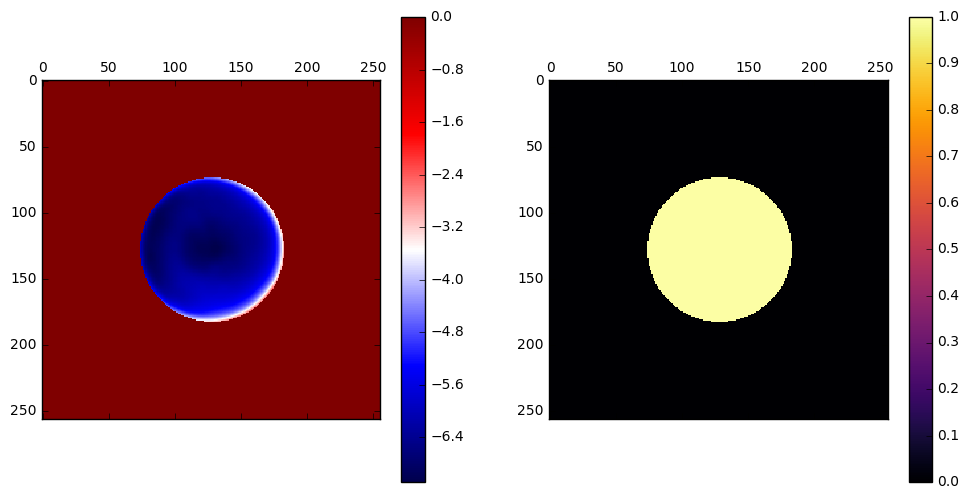

In [12]:
fig, axs = subplots(1, 2, figsize = (12, 6))
img1 = axs[0].matshow(result.phase, cmap="seismic")
colorbar(img1, ax=axs[0])
img2 = axs[1].matshow(result.mag, cmap="inferno")
colorbar(img2, ax=axs[1])
# figure()
# plot(abs(result.mse[:-1] - result.mse[1:])/result.mse[:-1])
# plot(result.mse_diff)
# figure()
# plot(result.pupil_diff[10:])
len(result.pupil_diff)

In [13]:
from psfotf.phaseretrieval import retrieve_phase as retrieve_phase2

25

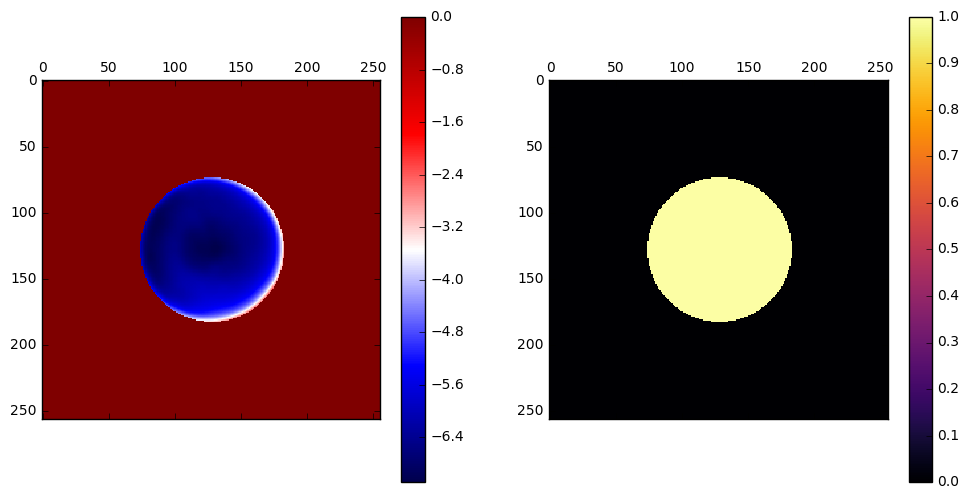

In [14]:
result2 = retrieve_phase2(junk, params, 25, phase_only=True)
fig, axs = subplots(1, 2, figsize = (12, 6))
img1 = axs[0].matshow(result2.phase, cmap="seismic")
colorbar(img1, ax=axs[0])
img2 = axs[1].matshow(result2.mag, cmap="inferno")
colorbar(img2, ax=axs[1])
len(result2.pupil_diff)

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:17<00:00,  1.40it/s]


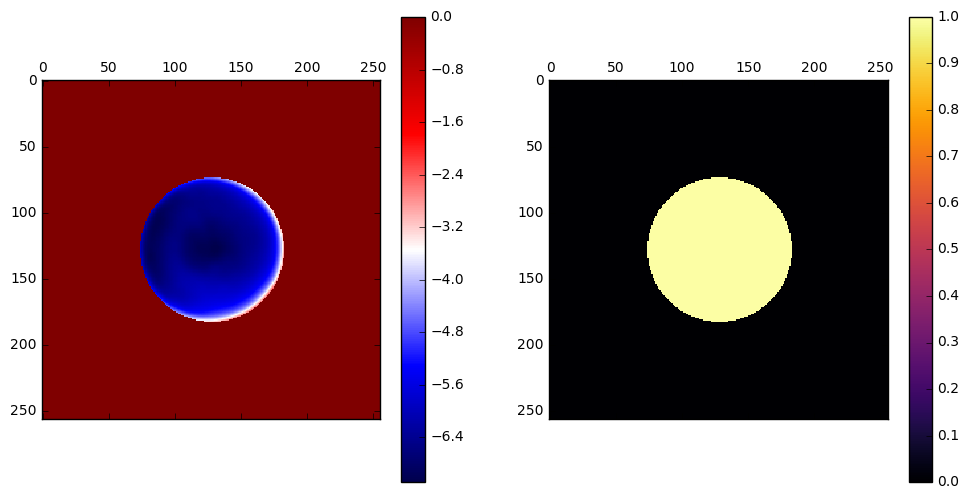

In [15]:
mag = psqrt(junk)
psf = HanserPSF(**params)
psf._gen_kr()
pupil = psf._gen_pupil()
for _ in tqdm.tqdm(range(25)):
    pupil, pupils = retrieve_phase_iter(mag, psf, pupil)
    pupil = exp(1j * angle(pupil)) * psf._gen_pupil().real
fig, axs = subplots(1, 2, figsize = (12, 6))
img1 = axs[0].matshow(unwrap_phase(fftshift(angle(pupil))) * fftshift(psf._gen_pupil().real), cmap="seismic")
colorbar(img1, ax=axs[0])
img2 = axs[1].matshow(fftshift(abs(pupil)), cmap="inferno")
colorbar(img2, ax=axs[1])

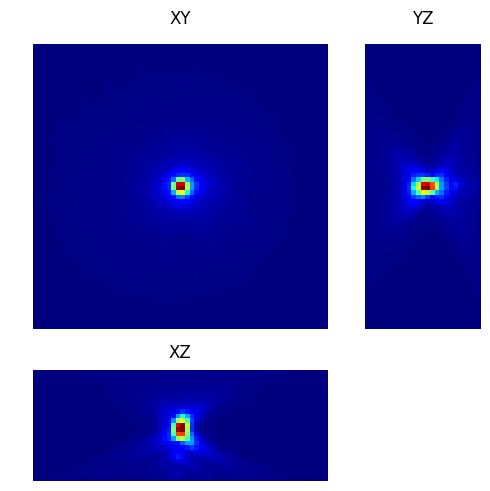

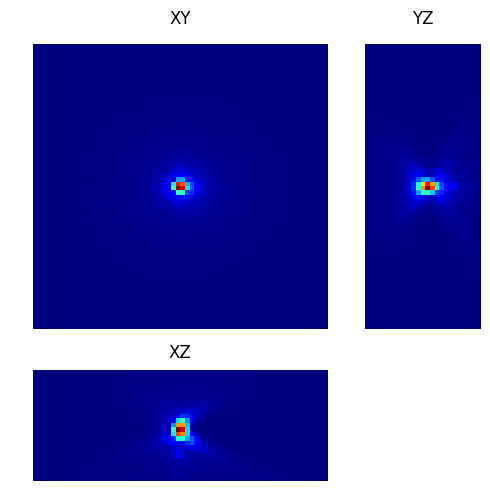

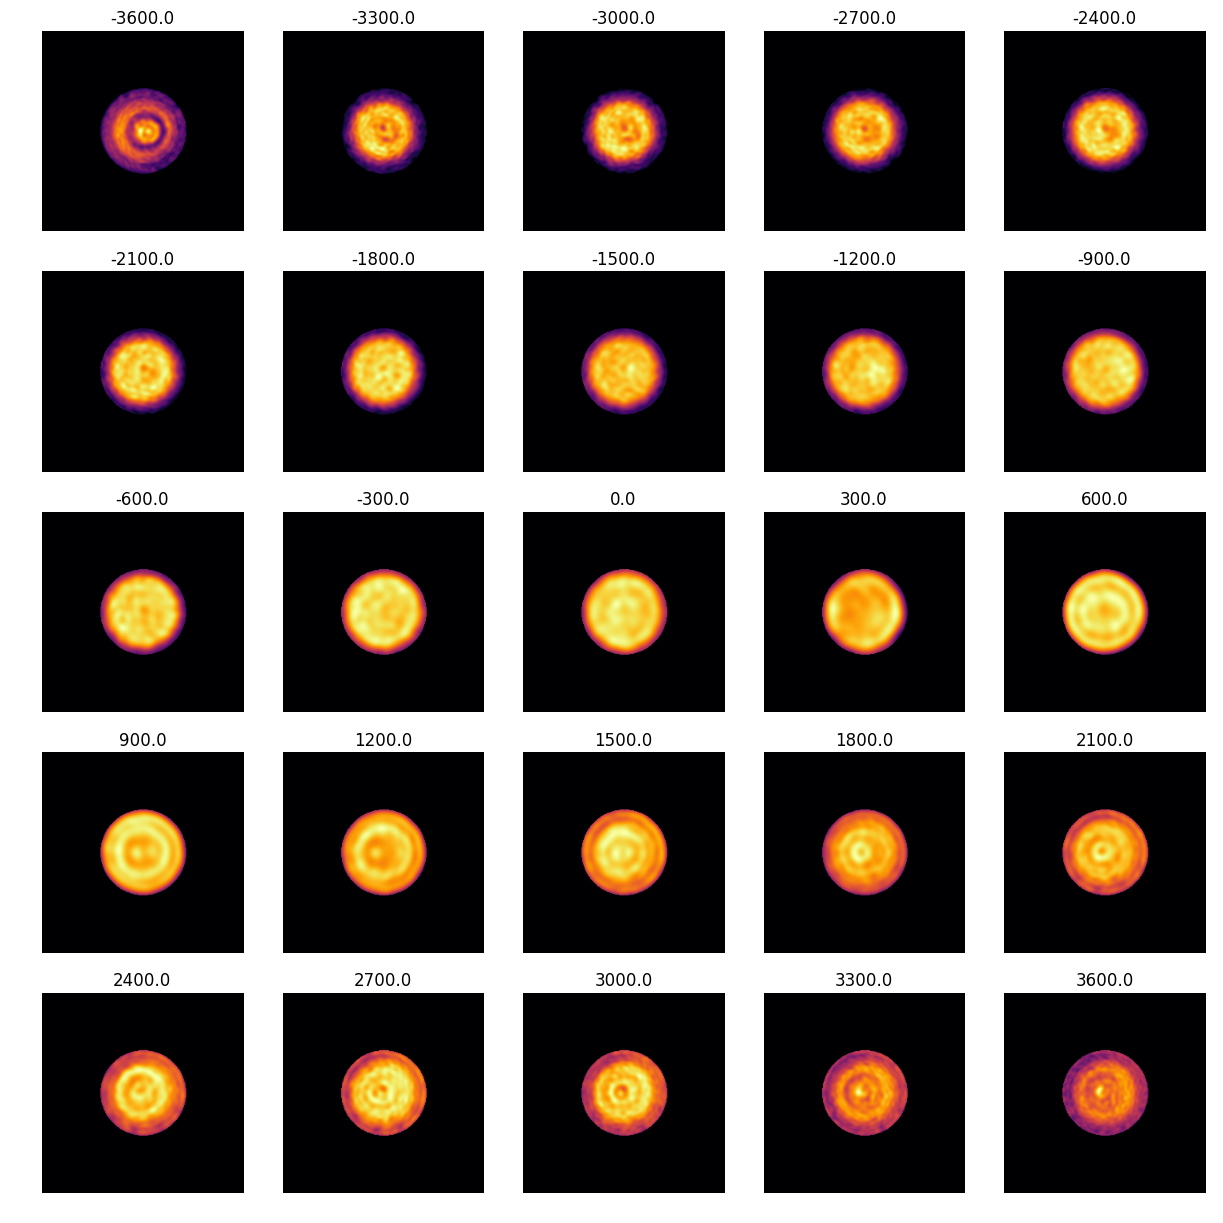

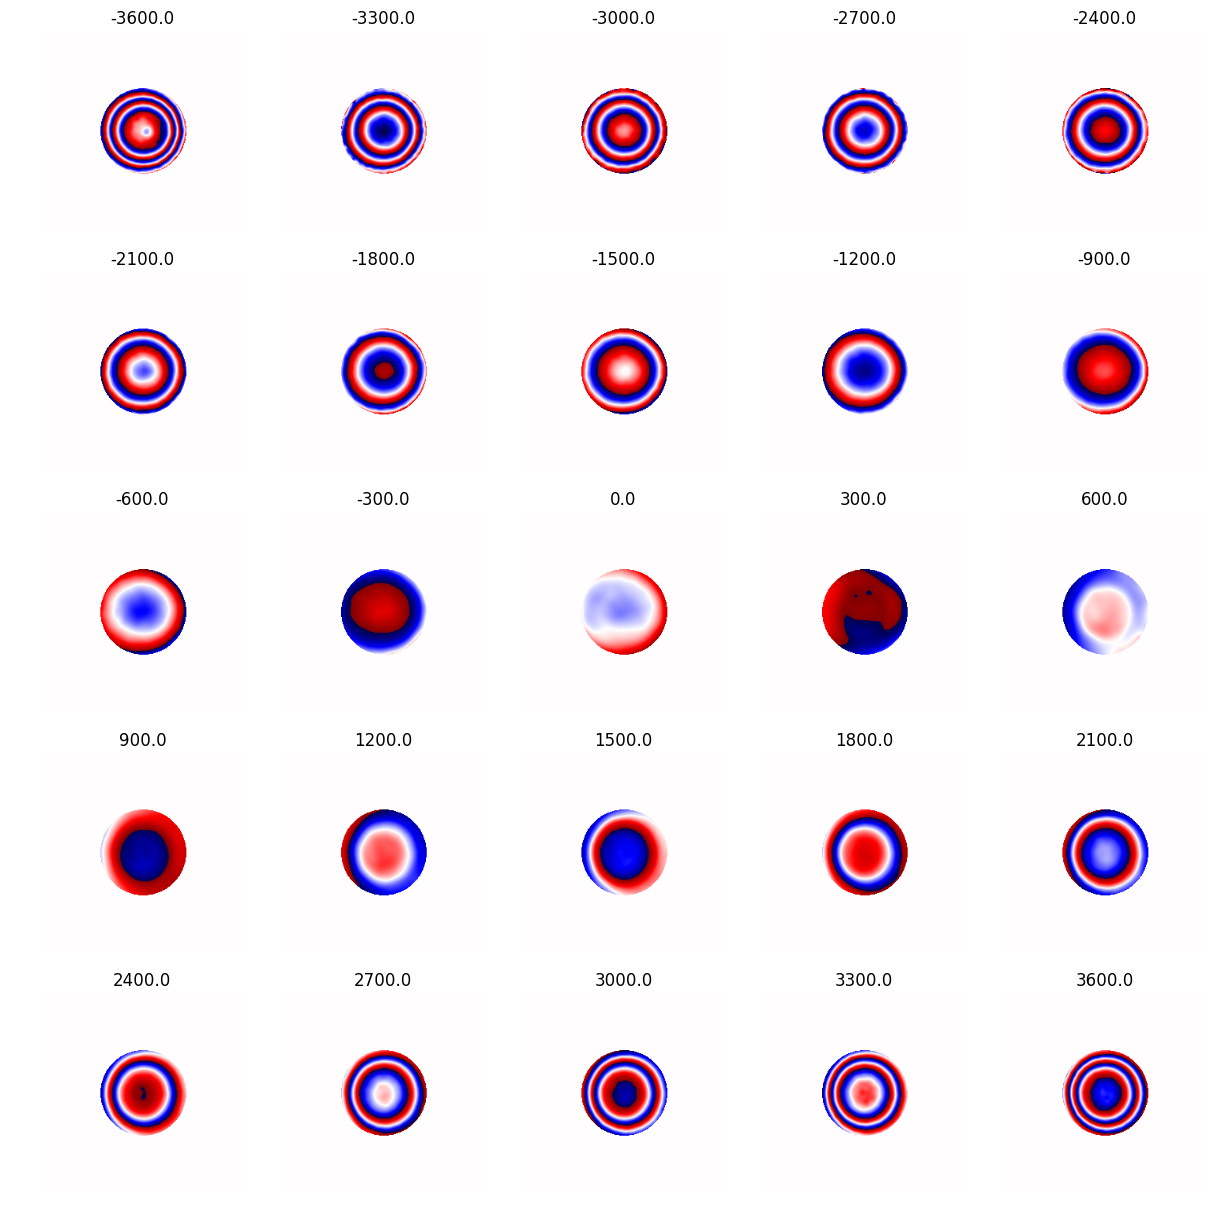

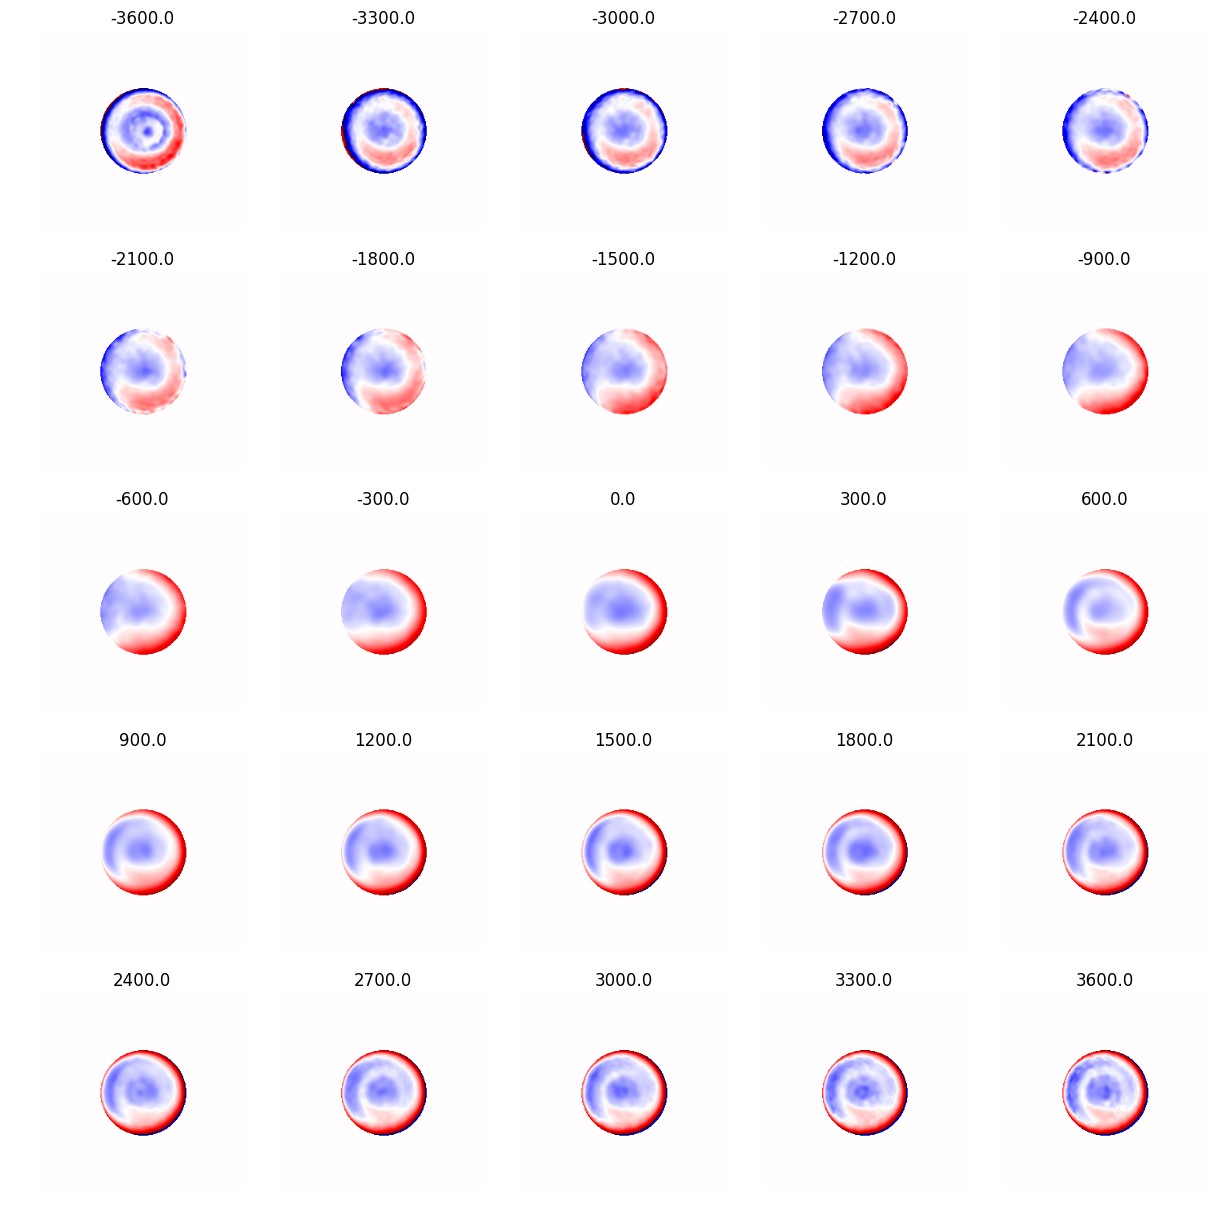

In [16]:
mip(junk[:, junk.shape[1] // 2 - 32:junk.shape[1] // 2 + 32, junk.shape[2] // 2 - 32:junk.shape[2] // 2 + 32])
psf._gen_psf(pupil)
mip(psf.PSFi[:,  junk.shape[1] // 2 - 32:junk.shape[1] // 2 + 32, junk.shape[2] // 2 - 32:junk.shape[2] // 2 + 32])

display_grid({z:fftshift(abs(pupil) * psf._gen_pupil().real)
              for z, pupil in zip(psf.zrange, pupils / psf._calc_defocus())},
            cmap="inferno");

display_grid({z:fftshift(angle(pupil) * psf._gen_pupil().real)
              for z, pupil in zip(psf.zrange, pupils)}, vmin=-pi, vmax=pi, cmap="seismic");

display_grid({z:fftshift(angle(pupil) * psf._gen_pupil().real)
              for z, pupil in zip(psf.zrange, pupils/psf._calc_defocus())},
             vmin=-pi, vmax=pi, cmap="seismic");

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:17<00:00,  1.40it/s]
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: RuntimeWarning: divide by zero encountered in log


{'condition': 'none',
 'na': 0.85,
 'ni': 1.0,
 'res': 130,
 'size': 256,
 'vec_corr': 'none',
 'wl': 520,
 'zres': 300,
 'zsize': 25}

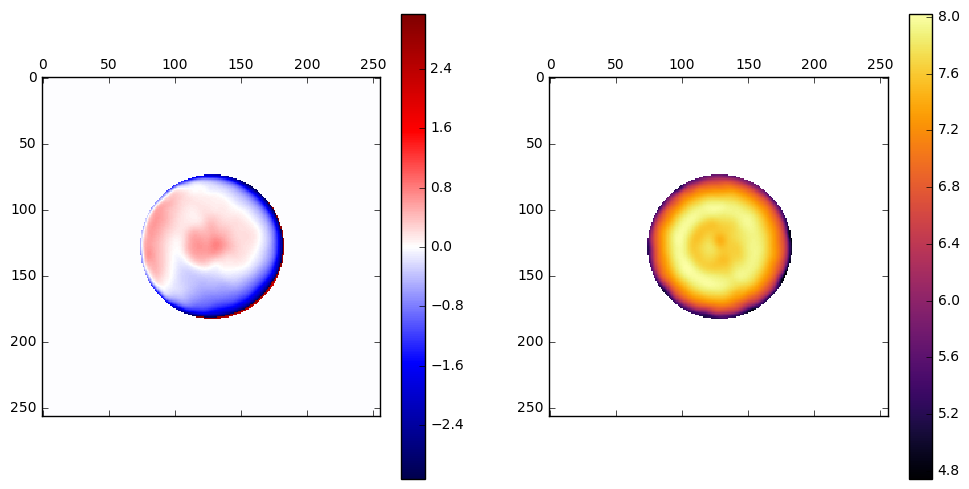

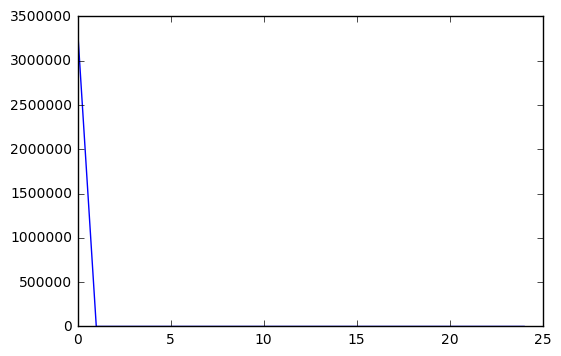

In [17]:
psf = HanserPSF(**params)
psf._gen_kr()
old_pupil2 = psf._gen_pupil()
mse2 = []
for _ in tqdm.tqdm(range(25)):
    pupil2, pupils2 = retrieve_phase_iter(mag, psf, old_pupil2)
    psf._PSFi = None
    mse2.append((abs(pupil2 - old_pupil2)**2).sum()/(abs(old_pupil2)**2).sum())
    old_pupil2 = pupil2
fig, axs = subplots(1, 2, figsize = (12, 6))
img1 = axs[0].matshow(fftshift(angle(conj(pupil2)) * psf._gen_pupil().real), cmap="seismic")
colorbar(img1, ax=axs[0])
img2 = axs[1].matshow(log(fftshift(abs(pupil2))), cmap="inferno")
colorbar(img2, ax=axs[1])
figure()
plot(mse2)
params

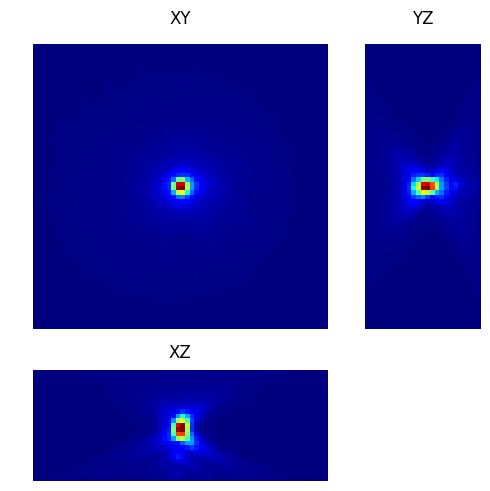

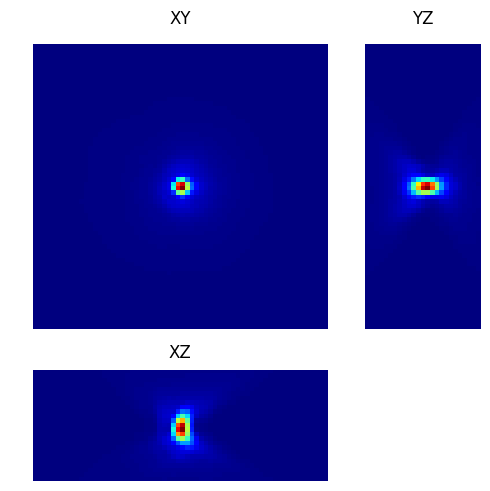

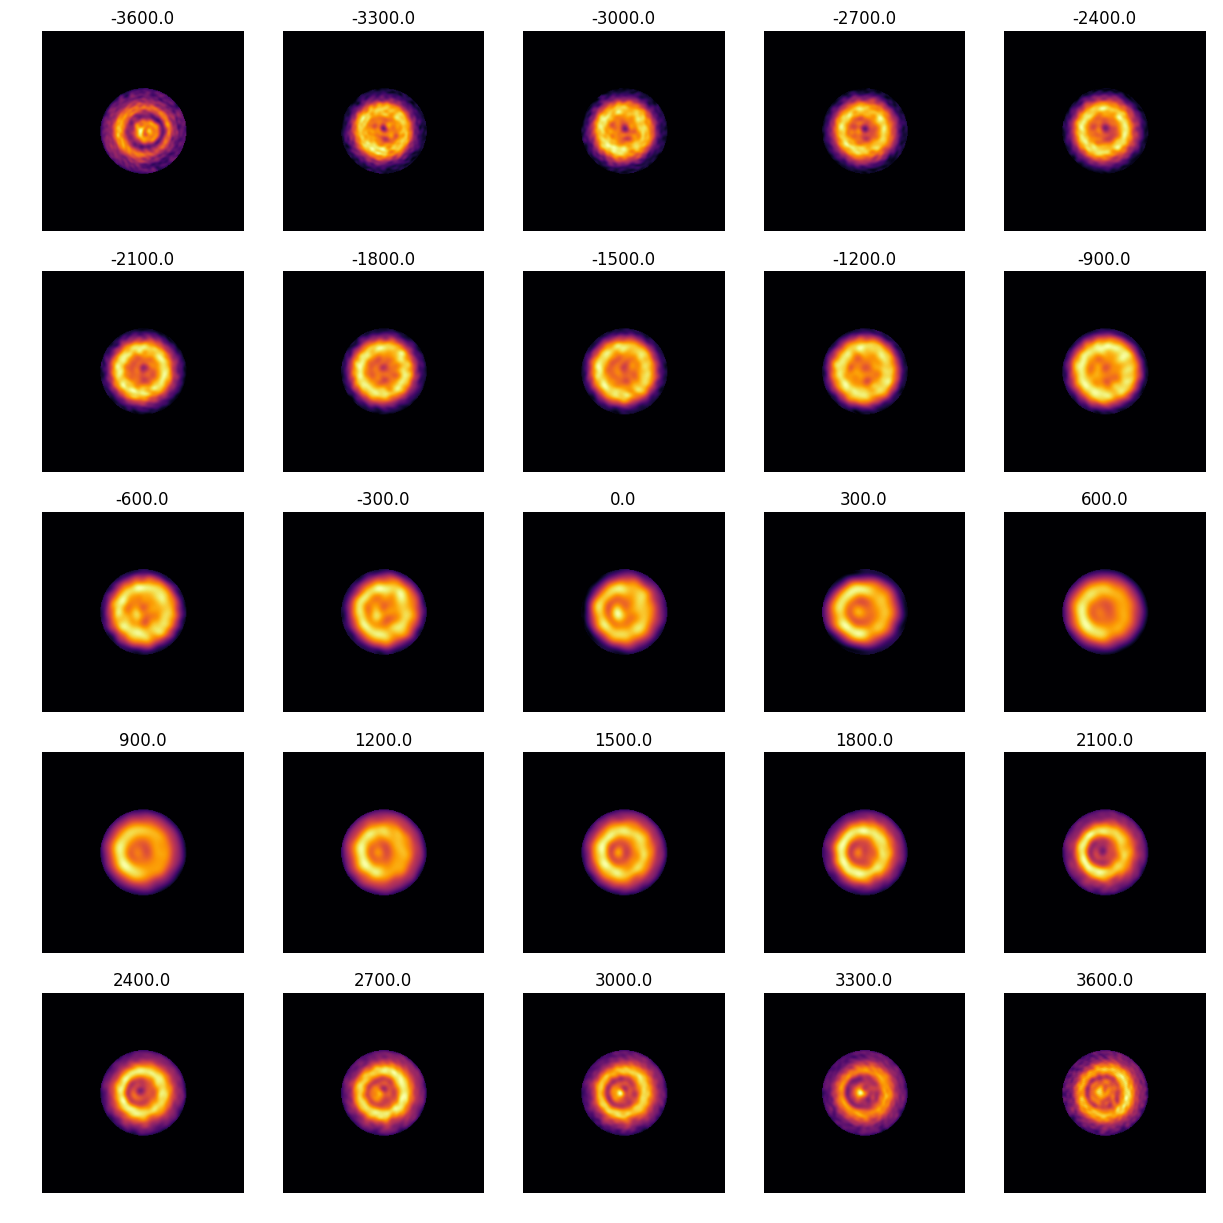

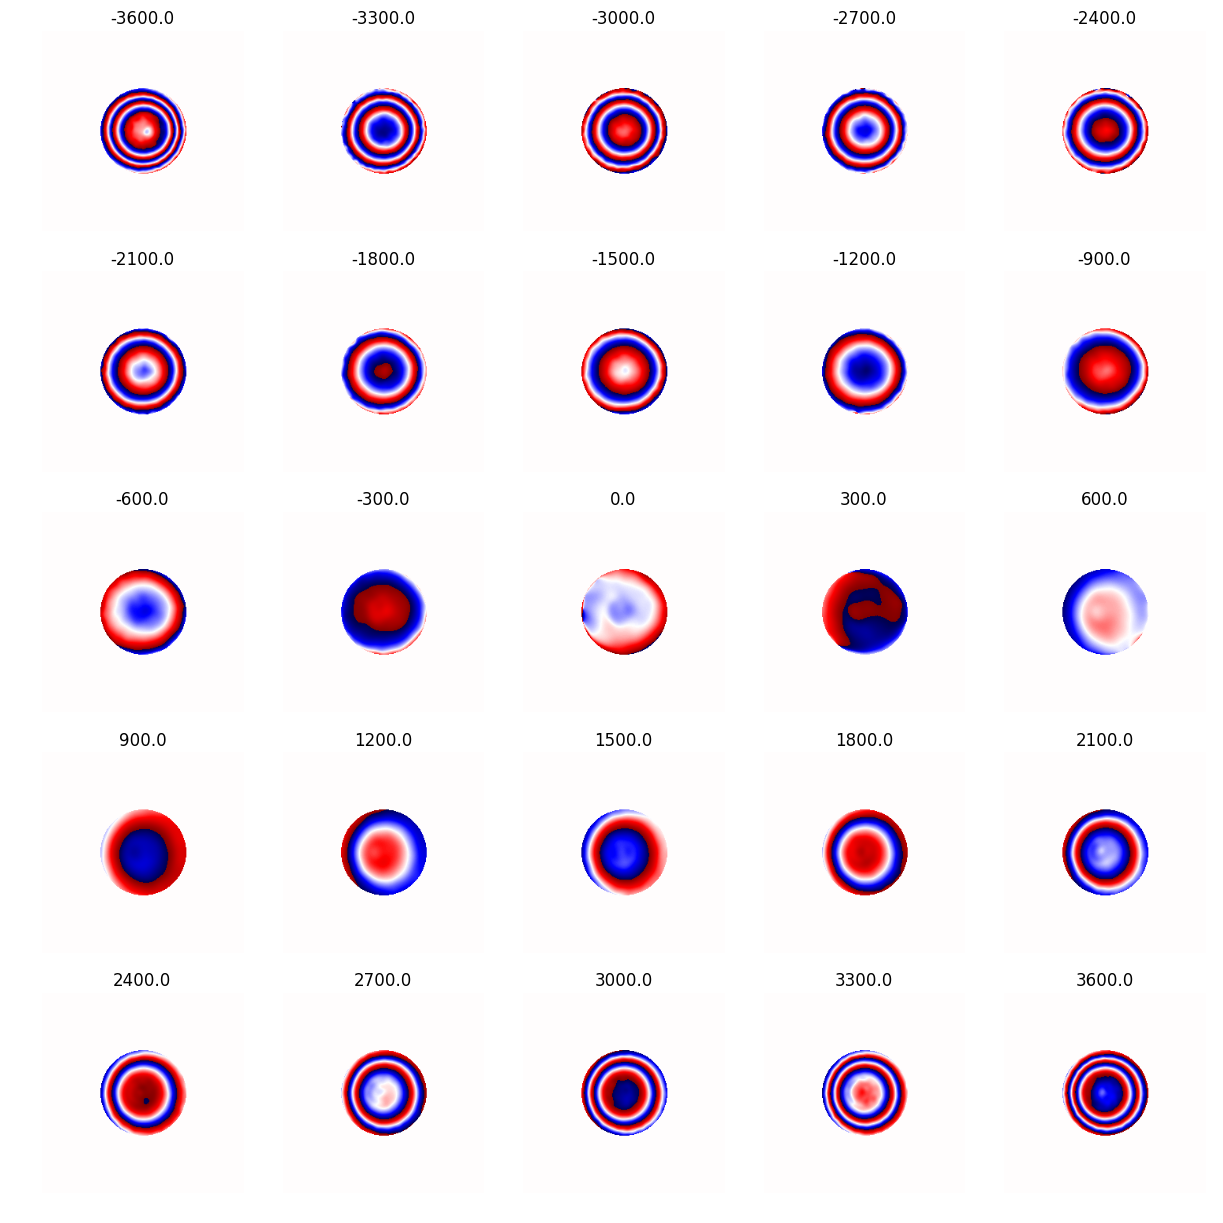

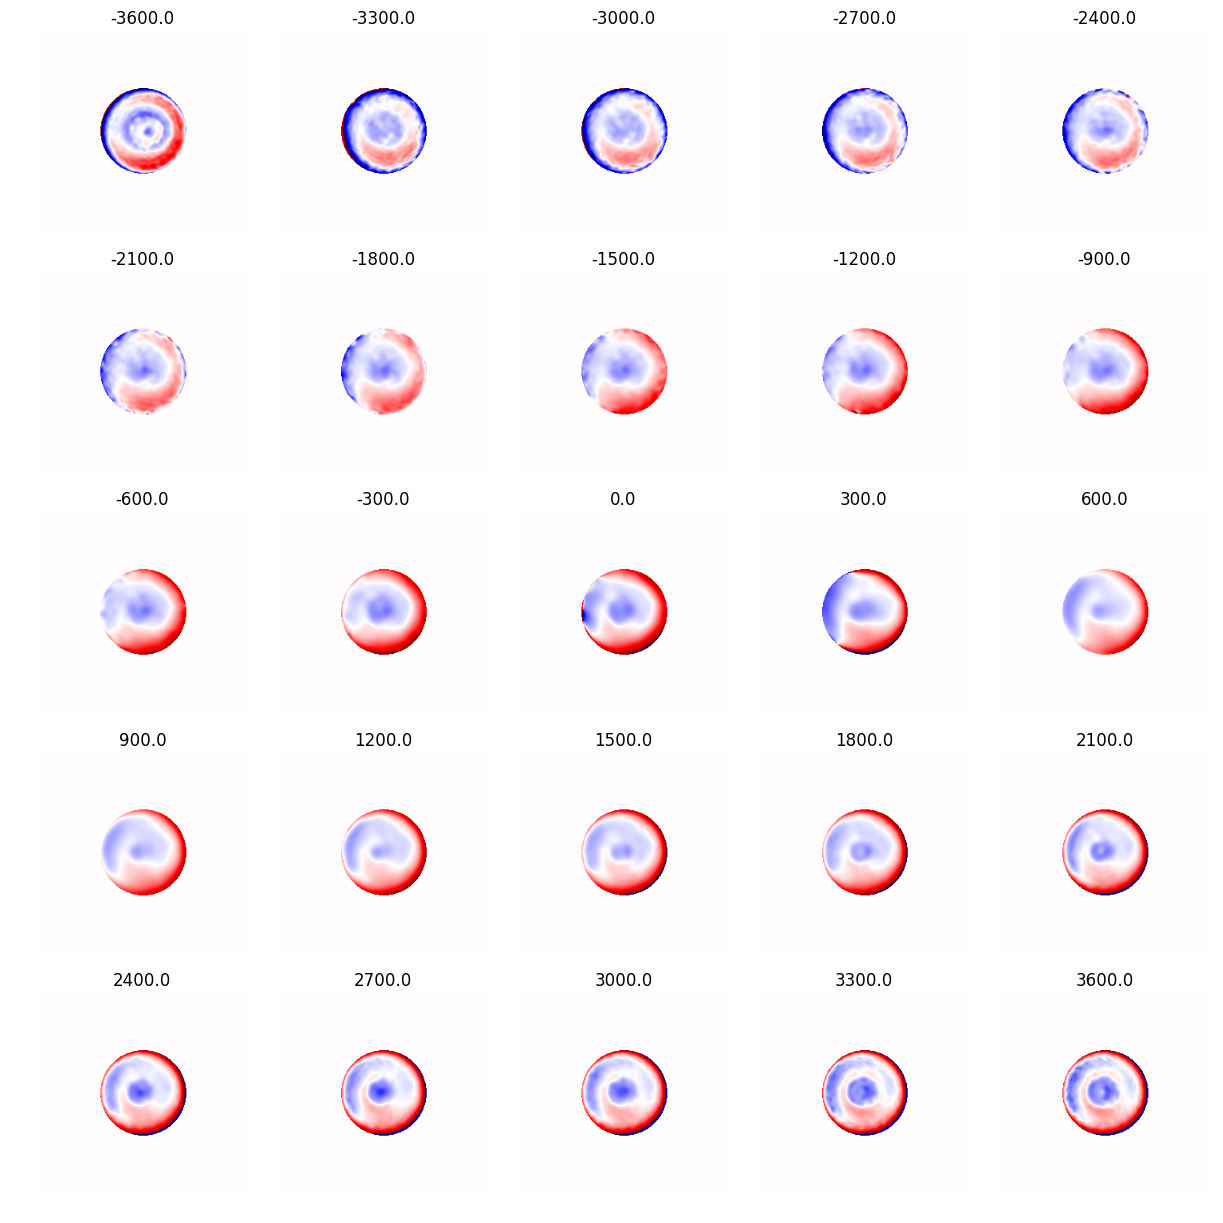

In [18]:
mip(junk[:, junk.shape[1] // 2 - 32:junk.shape[1] // 2 + 32, junk.shape[2] // 2 - 32:junk.shape[2] // 2 + 32])
psf._gen_psf(pupil2)
mip(psf.PSFi[:,  junk.shape[1] // 2 - 32:junk.shape[1] // 2 + 32, junk.shape[2] // 2 - 32:junk.shape[2] // 2 + 32])

display_grid({z:fftshift(abs(pupil2) * psf._gen_pupil().real)
              for z, pupil2 in zip(psf.zrange, pupils2 / psf._calc_defocus())},
            cmap="inferno");

display_grid({z:fftshift(angle(pupil2) * psf._gen_pupil().real)
              for z, pupil2 in zip(psf.zrange, pupils2)}, vmin=-pi, vmax=pi, cmap="seismic");

display_grid({z:fftshift(angle(pupil2) * psf._gen_pupil().real)
              for z, pupil2 in zip(psf.zrange, pupils2/psf._calc_defocus())},
             vmin=-pi, vmax=pi, cmap="seismic");

(<matplotlib.figure.Figure at 0x1aa5eb00780>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001AA5B4FE7F0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001AA5B4C1A20>], dtype=object))

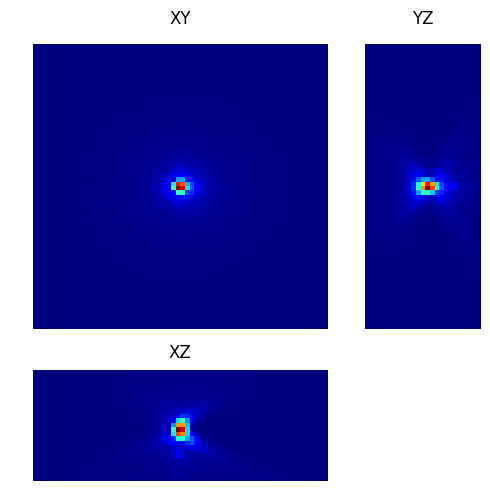

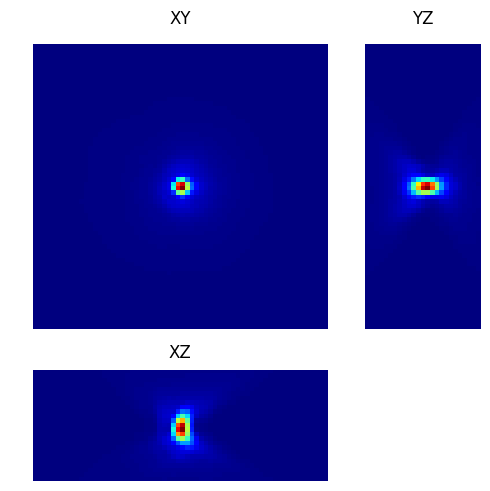

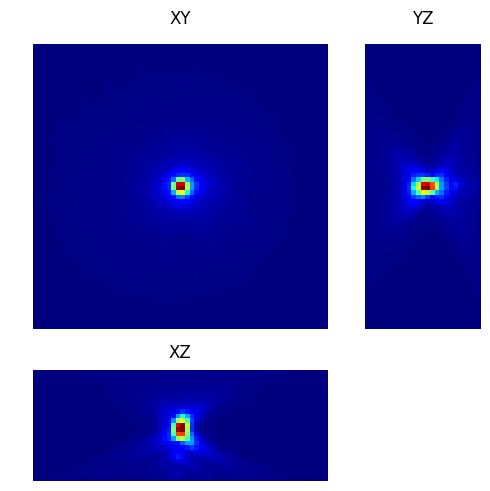

In [19]:
psf._gen_psf(pupil)
psf._PSFi=None
nx = test_data.shape[-1]//2
mip(psf.PSFi[[Ellipsis] + [slice(nx-32, nx+32)]*2])
psf._gen_psf(pupil2)
psf._PSFi=None
mip(psf.PSFi[[Ellipsis] + [slice(nx-32, nx+32)]*2])
mip(junk[[Ellipsis] + [slice(nx-32, nx+32)]*2])

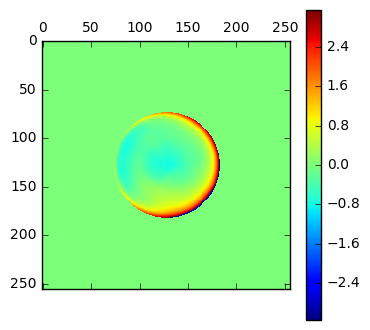

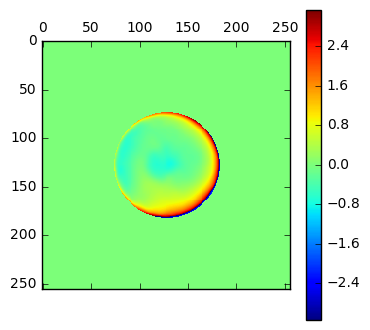

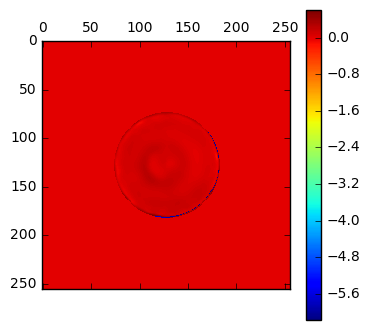

In [20]:
matshow(fftshift(psf._gen_pupil().real) * (fftshift(angle(pupil))))
colorbar()
matshow(fftshift(psf._gen_pupil().real) * (fftshift(angle(pupil2))))
colorbar()
matshow(fftshift(psf._gen_pupil().real) * (fftshift(angle(pupil2)-angle(pupil))))
colorbar()

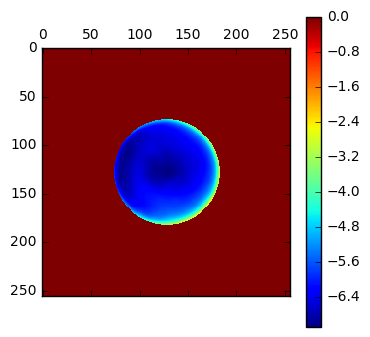

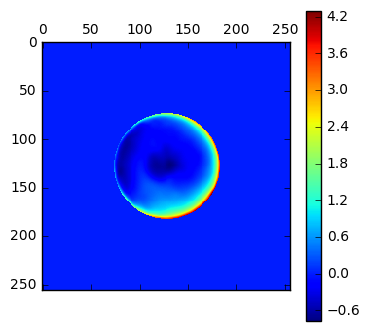

In [21]:
matshow(fftshift(psf._gen_pupil().real) * unwrap_phase(fftshift(angle(pupil))))
colorbar()
matshow(fftshift(psf._gen_pupil().real) * unwrap_phase(fftshift(angle(pupil2))))
colorbar()

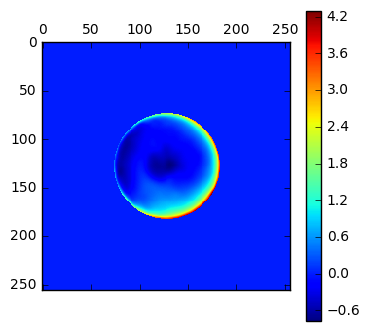

In [22]:
matshow(fftshift(psf._gen_pupil().real) * unwrap_phase(fftshift(angle(pupil2))))
colorbar()

(<matplotlib.figure.Figure at 0x1aa5bf40be0>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001AA6033CE80>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001AA60453198>], dtype=object))

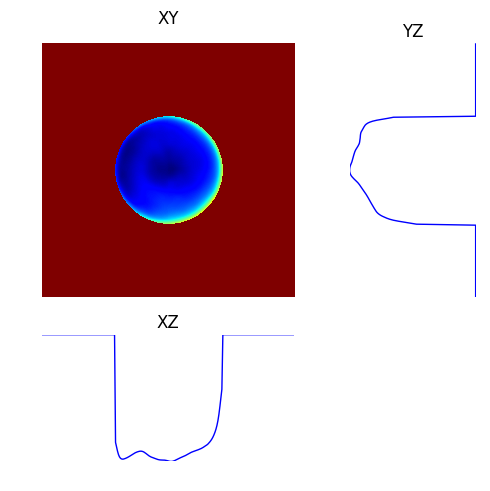

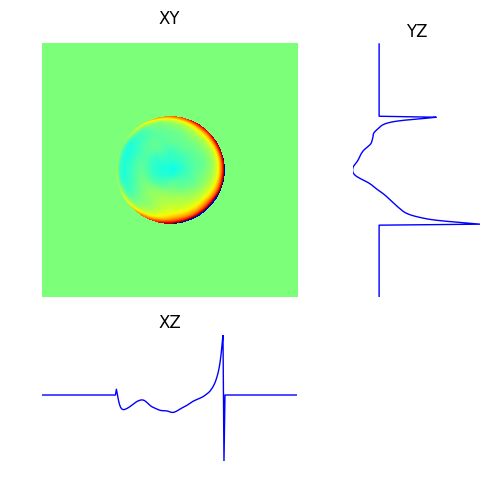

In [23]:
unwrapped = fftshift(psf._gen_pupil().real) * unwrap_phase(fftshift(angle(pupil)))
original = fftshift(psf._gen_pupil().real) * (fftshift(angle(pupil)))
slice_plot(unwrapped)
slice_plot(original)

(<matplotlib.figure.Figure at 0x1aa5ed9fb00>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001AA59932198>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001AA5B954A90>], dtype=object))

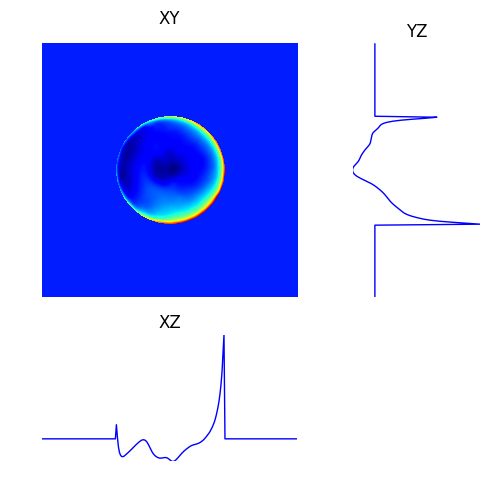

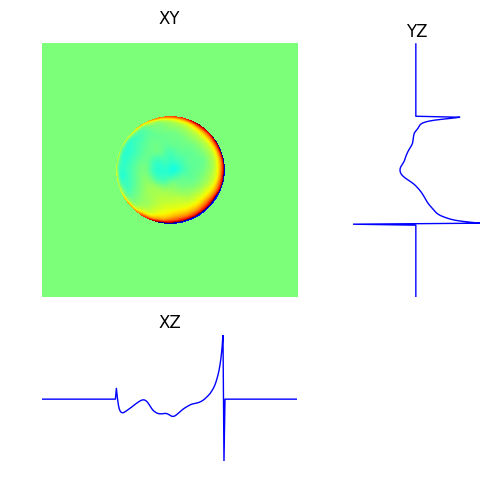

In [24]:
unwrapped = fftshift(psf._gen_pupil().real) * unwrap_phase(fftshift(angle(pupil2)))
original = fftshift(psf._gen_pupil().real) * (fftshift(angle(pupil2)))
slice_plot(unwrapped)
slice_plot(original)